# 1D quantum Gradient Echo Memory equations with XMDS2

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

In [2]:
plt.rcParams["legend.fontsize"] = 6;
plt.rcParams['figure.dpi'] = 150; # Changes figsize when displayed in notebook

In [3]:
# Load the data from a file
def load_instance(filename):
    with h5py.File(filename, "r") as f:
        dst = f['1'] # Dataset
        t, z, = (dst['t'][:], dst['z'][:])
        S_im, S_re, E_im, E_re = (dst['SI'][:], dst['SR'][:], dst['EI'][:], dst['ER'][:])
        # Indexing with [:] converts from 'dataset' to 'np.ndarray'.
        # Each row corresponds with a time, and each column with a z-position.
        S = S_re + S_im * 1j
        E = E_re + E_im * 1j
        return (t, z, E, S)

In [4]:
# Performance measures
def performance(t,z,E,S, tswitch): # FOR SIMPLE GRADIENT-SWITCH
    # This function assumes time samples are evenly spaced.
    # The output pulse is reversed; so we can compare by taking the first
    # switch_index samples *after* switch_index, and reversing that.
    # The input pulse is ignored after t_switch.
    switch_index = int(len(t) * (tswitch - min(t))/(max(t) - min(t)))
    if len(t) < 2*switch_index:
        print("WARNING: duration < 2 * t_switch. Cannot fairly compare pulses.")
        return None, None
    Ein = E[:switch_index,0]
    tin = t[:switch_index]
    Eout = np.flip(E[switch_index:2*switch_index,-1]) # Excludes initial leakage
    # Norm is proportional to energy
    norm_in = simpson(np.power(np.abs(Ein),2), tin)
    norm_out = simpson(np.power(np.abs(Eout), 2), tin)
    efficiency = np.abs(norm_out/norm_in);
    fidelity = np.abs(simpson(np.conj(Ein) * Eout, tin)) / np.sqrt(norm_in * norm_out)
    
    return efficiency, fidelity

In [5]:
# Summary plots of a run
def summary_plot(t,z,E,S, tswitch, name=""):
    fig, axs = plt.subplots(2,2, figsize=(6,4.5));
    (axTL, axTR, axBL, axBR) = (axs[0,0], axs[0,1], axs[1,0], axs[1,1])
    
    # Plot density
    tmin, tmax, zmin, zmax = (min(t), max(t), min(z), max(z))
    imopts = {"cmap":'plasma', "interpolation":'bicubic', 
              "extent":[zmin, zmax,tmin, tmax], "aspect":"auto",
              "origin": "lower"}
    
    ## Probe
    axTL.imshow(np.abs(E), **imopts)
    axTL.set_title("Probe")
    axTL.set_xlabel("z"); axTL.set_ylabel("t")
    axTL.axhline(tswitch, ls="--", color="r")
    
    ## Spinwave
    axTR.imshow(np.abs(S), **imopts)
    axTR.set_title("Spinwave")
    axTR.set_xlabel("z"); axTR.set_ylabel("t")
    axTR.axhline(tswitch, ls="--", color="r")
    
    # Input and output pulses
    axBL.plot(t, np.real(E[:,0]), label = "In (Re)")
    axBL.plot(t, np.real(E[:,-1]), label = "Out (Re)")
    axBL.plot(t, np.imag(E[:,-1]), label = "Out (Im)")
    axBL.axvline(tswitch, ls="--", color="r")
    axBL.set_xlabel("t"); axBL.set_ylabel("Light amplitude")
    axBL.legend()
    axBL.set_title("Input and output pulses")
    
    # Spinwave at t_switch
    switch_index = int(len(t) * (tswitch - tmin)/(tmax - tmin))
    axBR.plot(z, np.abs(S[switch_index, :]))
    axBR.set_title("Spinwave at t_switch")
    axBR.set_xlabel("z"); axBR.set_ylabel("Magnitude")
    
    eff, fid = performance(t,z,E,S,tswitch)
    fig.suptitle(f"{name}     (Efficiency: {eff:.2f},    Fidelity: {fid:.2f})")
    fig.tight_layout()

## Reversal demonstration

In [6]:
# Some general notes: no matter what (time-dependent) manipulations we make to
# our control field, we can always recreate the input pulse (provided we captured
# most of it to start with), by reversing our manipulations after a given point in time.
# TODO: demo this.

In [49]:
triangle = load_instance("./instances/triangle/bandwidth=4.h5")
highbandwidth_triangle = load_instance("./instances/triangle/bandwidth=8.h5")

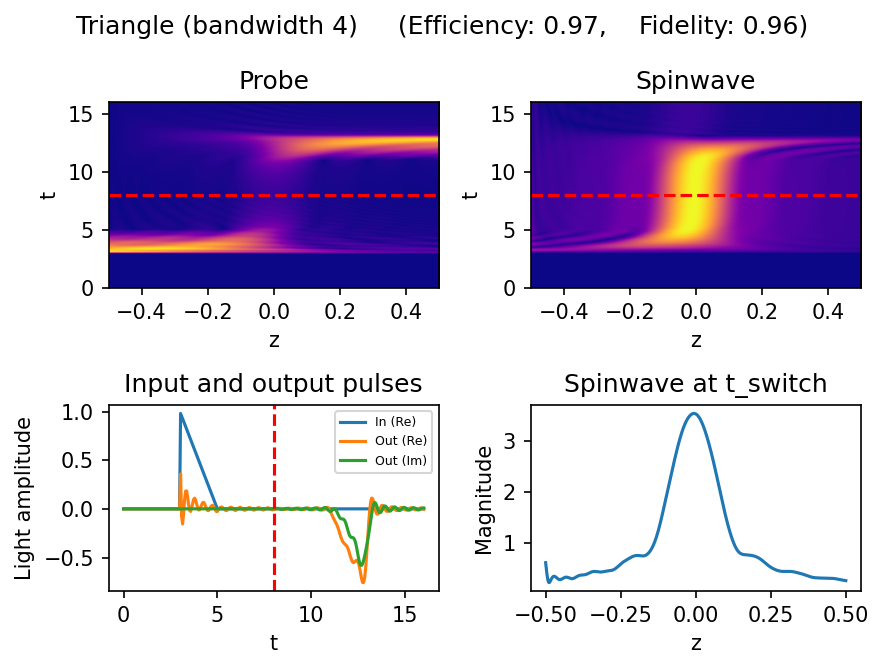

In [50]:
summary_plot(*triangle, 8, "Triangle (bandwidth 4)")
#summary_plot(*triangle, 8, "Triangle (bandwidth 8)")
# Illustrates time and phase reversal.
# I would expect increasing the bandwidth to increase fidelity, but in this case it didn't?

## Lifetime benchmarking with square pulse

### Known-duration storage using continual rotation

In [55]:
# Extract just the first period of 2*tswitch:
def upto(t, z, E, S, T):
    i = int(len(t) * (T-min(t))/(max(t)-min(t)))
    return (t[:i],z,E[:i,:],S[:i,:])

In [56]:
# Square pulse also demonstrates Gibbs overshoot? (may be numerical)
tophat_8_all = load_instance("./instances/tophat/tswitch=8.h5")
tophat_20_all = load_instance("./instances/tophat/tswitch=20.h5")
tophat_40_all = load_instance("./instances/tophat/tswitch=40.h5")
tophat_8 = upto(*tophat_8_all, 18)
tophat_20 = upto(*tophat_20_all, 45)
tophat_40 = upto(*tophat_40_all, 90)

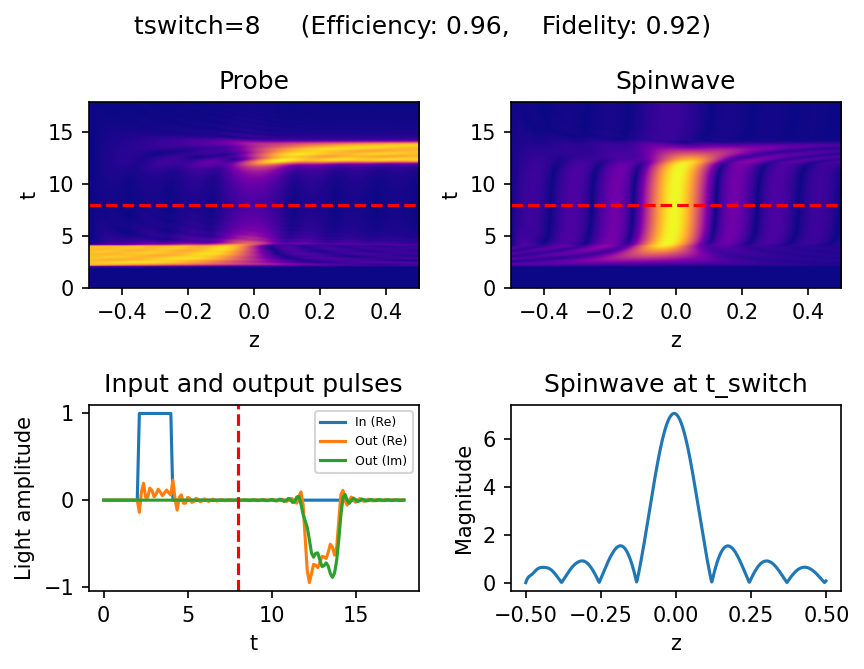

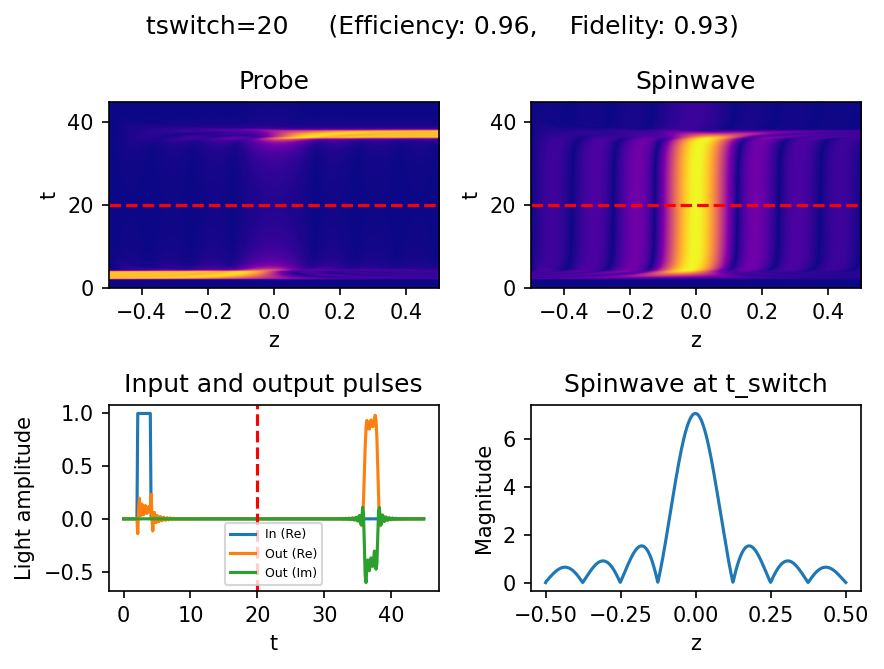

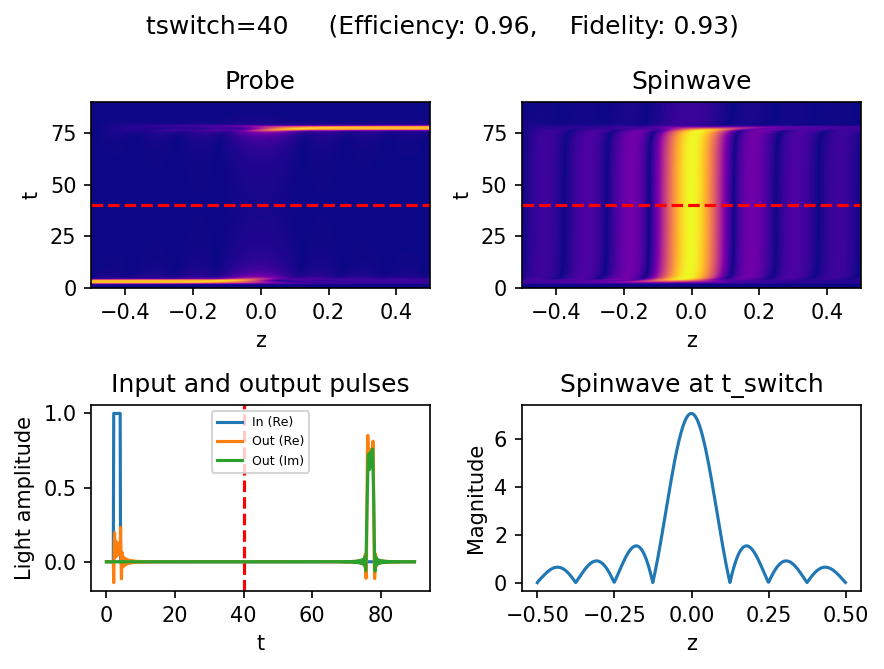

In [57]:
summary_plot(*tophat_8, 8, "tswitch=8")
summary_plot(*tophat_20, 20, "tswitch=20")
summary_plot(*tophat_40, 40, "tswitch=40")
# TODO: ask Joe if you can make interval an argument

### On-demand release by turning off the control field

In [11]:
# Question: how does the lifetime of this method compare with known-duration release?

# Observation: the spinwave in this regime seems to slowly travel to the right.
# Is this what is meant by slowing down / freezing light?

In [58]:
def ondemand_performance(t,z,E,S, toff, trelease): # FOR ON-DEMAND
    off_index = int(len(t) * (toff - min(t))/(max(t) - min(t)))
    release_index = int(len(t) * (trelease - min(t))/(max(t) - min(t)))
    if max(t) < toff + trelease:
        print("ERROR: output pulse truncated. Cannot fairly compare pulses.")
        return None, None
    Ein = E[:off_index,0]
    tin = t[:off_index]
    Eout = np.flip(E[release_index:release_index+off_index,-1])
    # Norm is proportional to energy
    norm_in = simpson(np.power(np.abs(Ein),2), tin)
    norm_out = simpson(np.power(np.abs(Eout), 2), tin)
    efficiency = np.abs(norm_out/norm_in);
    fidelity = np.abs(simpson(np.conj(Ein) * Eout, tin)) / np.sqrt(norm_in * norm_out)
    
    return efficiency, fidelity

In [61]:
ondemand_8_15 = upto(*load_instance("./instances/ondemand/trelease=15.h5"), 26)
ondemand_8_30 = upto(*load_instance("./instances/ondemand/trelease=30.h5"), 45)

In [27]:
from IPython.display import display, Markdown

## Actual performance: Efficiency 0.96, Fidelity 0.93

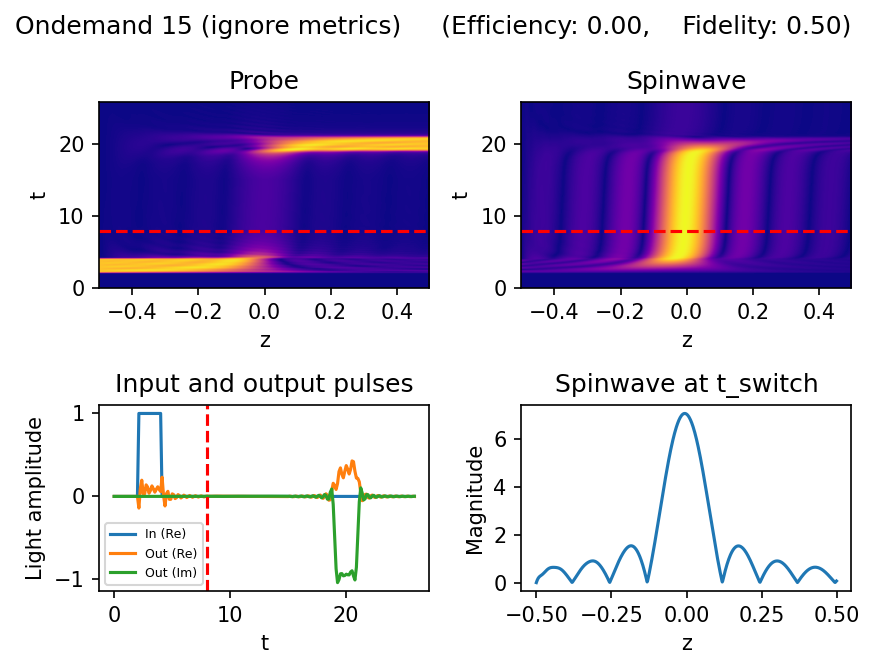

In [62]:
summary_plot(*ondemand_8_15, 8, "Ondemand 15 (ignore metrics)")
display(Markdown("## Actual performance: Efficiency {:.2f}, Fidelity {:.2f}".format(
    *ondemand_performance(*ondemand_8_15, 8, 15))))

## Actual performance: Efficiency 0.96, Fidelity 0.91

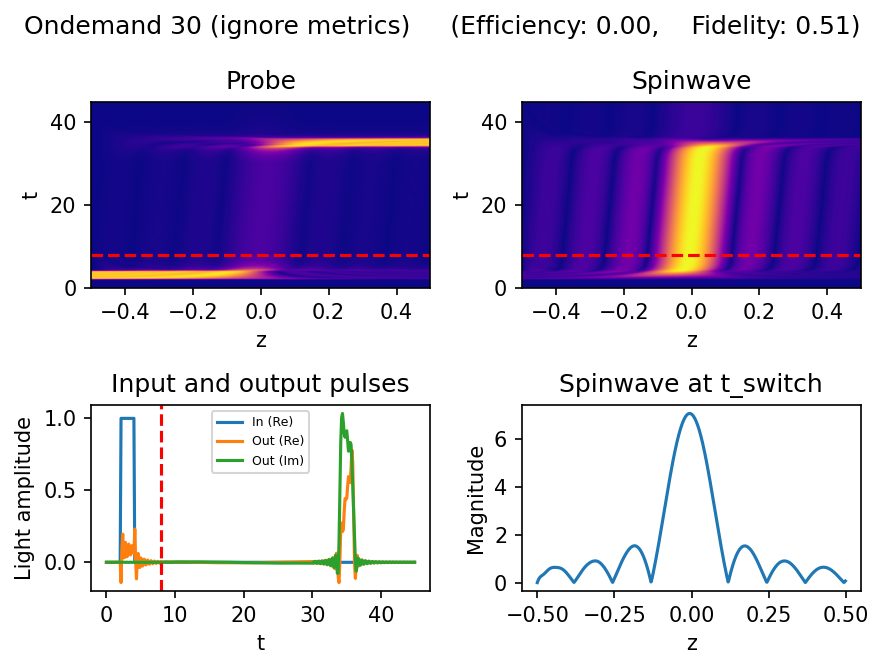

In [63]:
summary_plot(*ondemand_8_30, 8, "Ondemand 30 (ignore metrics)")
display(Markdown("## Actual performance: Efficiency {:.2f}, Fidelity {:.2f}".format(
    *ondemand_performance(*ondemand_8_30, 8, 30))))

## A tour of Fourier phenomena

In [ ]:
#gauss = load_instance("./instances/gaussian/jesse-gaussian.h5")
#summary_plot(*gauss, 8)

In [42]:
# Double Gaussian pulse -> cosine-modulated Gaussian FT
    # Change pulsewidth -> observe envelope change
    # Change separation -> observe carrier change

# OBSERVATION: the net phase shift between the input and output pulses
# (which remains relatively constant over the width of a single pulse)
# actually changes with time, which is revealed by this situation
# where our signal consists of two time-separated pulses.
# QUESTION: what is the relationship betwee time and phase shift, and can we correct for it?
# FOR EXAMPLE: if you pass the output signal through _another_ GEM, the phase shift might be reversed
# (hence corrected). This would also correct the time-reversal of the signal.
# Moreover, the scheme could be implemented within a _single_ GEM cell, by having a two-part
# control field: 

#'//' (capture in first half, duration T) 
# -> '\/' release from first, capture in second (duration 2T)
# -> '\\' release final pulse, duration >= T

# Scheme explored in the 'nonlinear' section. How does it affect the fidelity?

In [64]:
# Load datasets
#dbl_gauss_w15_sep2 = load_instance("./instances/double-gaussian/pulsewidth=1.5.pulsesep=2.h5")
dbl_gauss_w05_sep2 = load_instance("./instances/double-gaussian/pulsewidth=0.5.pulsesep=2.h5")
dbl_gauss_w15_sep4 = load_instance("./instances/double-gaussian/pulsewidth=1.5.pulsesep=4.h5")
dbl_gauss_w05_sep4 = load_instance("./instances/double-gaussian/pulsewidth=0.5.pulsesep=4.h5")

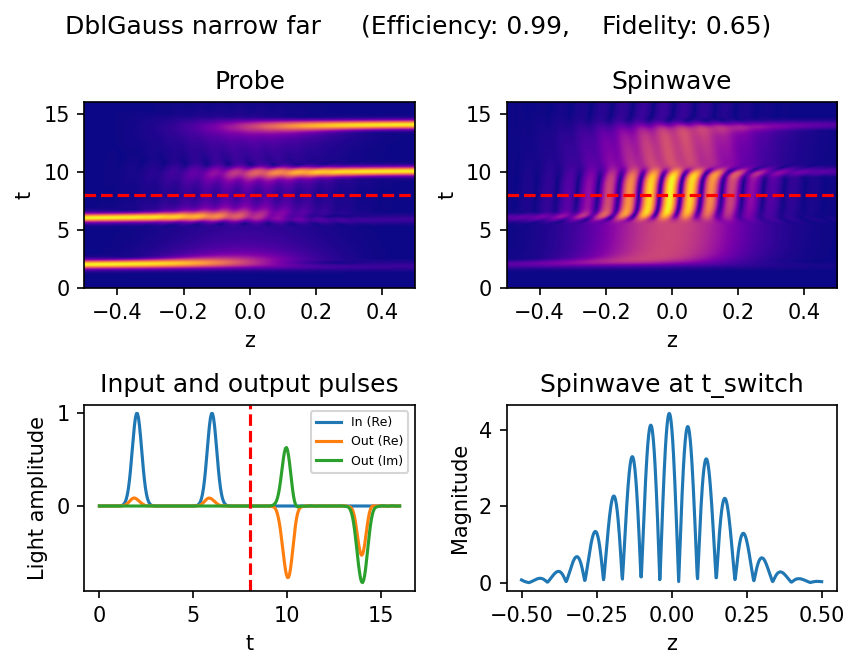

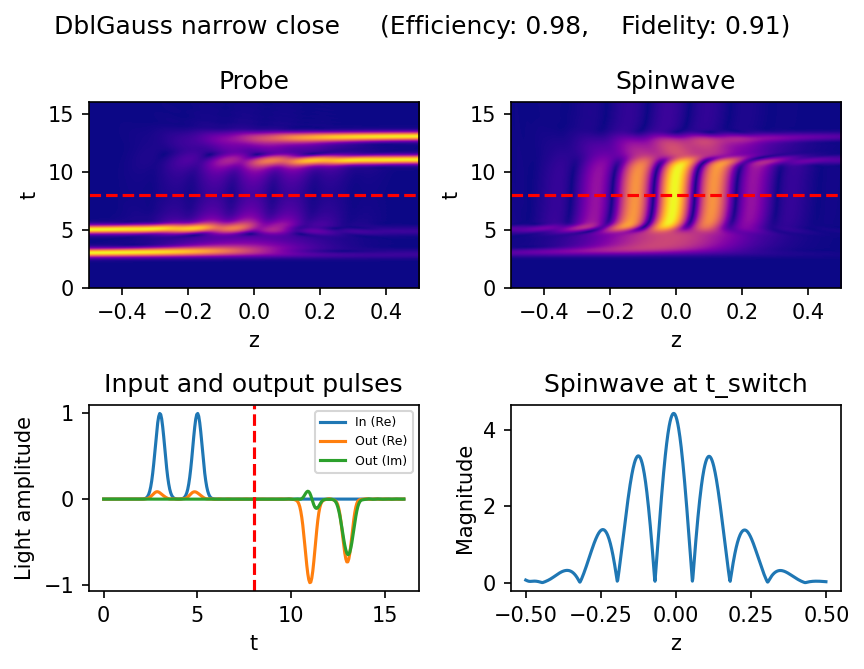

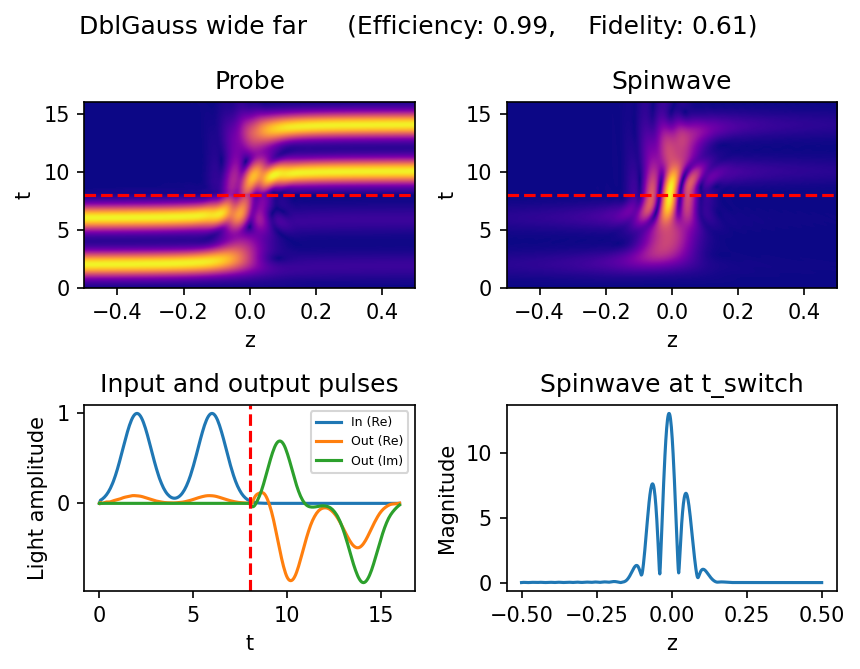

In [65]:
#summary_plot(*dbl_gauss_w15_sep2, 8, "DblGauss wide close")
summary_plot(*dbl_gauss_w05_sep4, 8, "DblGauss narrow far") # Initial
summary_plot(*dbl_gauss_w05_sep2, 8, "DblGauss narrow close")# FT carrier changed, envelope same
summary_plot(*dbl_gauss_w15_sep4, 8, "DblGauss wide far") # FT carrier same, envelope changed

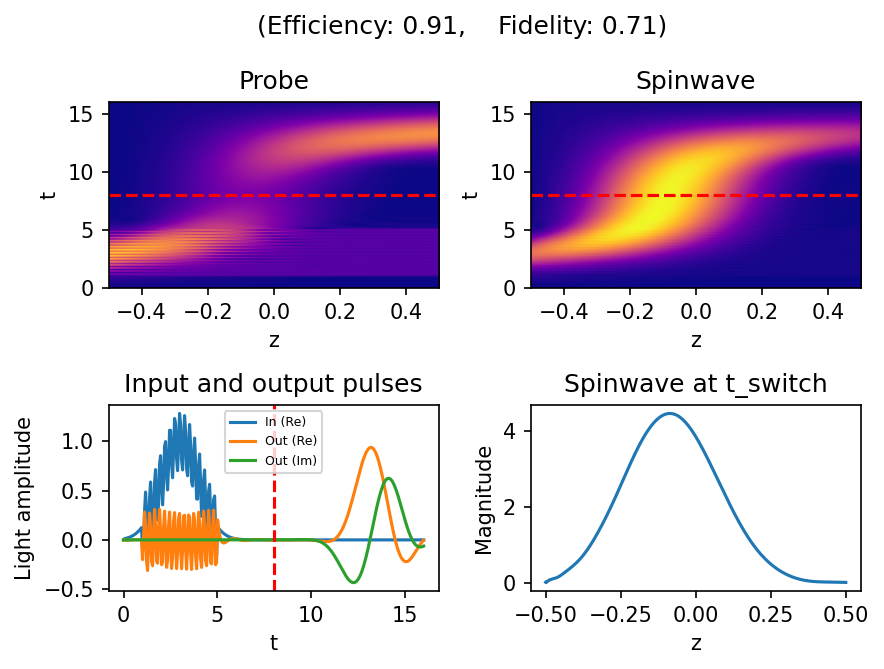

In [68]:
# Filtering of a cosine-dithered Gaussian to remove fast frequency.
# This is an effect of limited bandwidth; we can see the light corresponding with the fast cosine component
# passing through without being absorbed.
# i.e. low-pass filter. Demonstrates leakage (frequency).
dithered = load_instance("./instances/low-pass-filter/dithered-gaussian.h5")
summary_plot(*dithered, 8)

In [ ]:
# 'Transform clipping': if only some frequencies contain too much amplitude
# to be stored, then the amplitude of these frequencies will be 'clipped'
# in the transform/output. (to isolate this effect, use large storage bandwidth
# or narrow-band input signal). Frequency amplitude clipping is not something we come across
# as often in signal processing.
# Normal Gaussian. Demonstrates leakage (amplitude).

# In this case the effect is demonstrated by adjusting the optical depth.

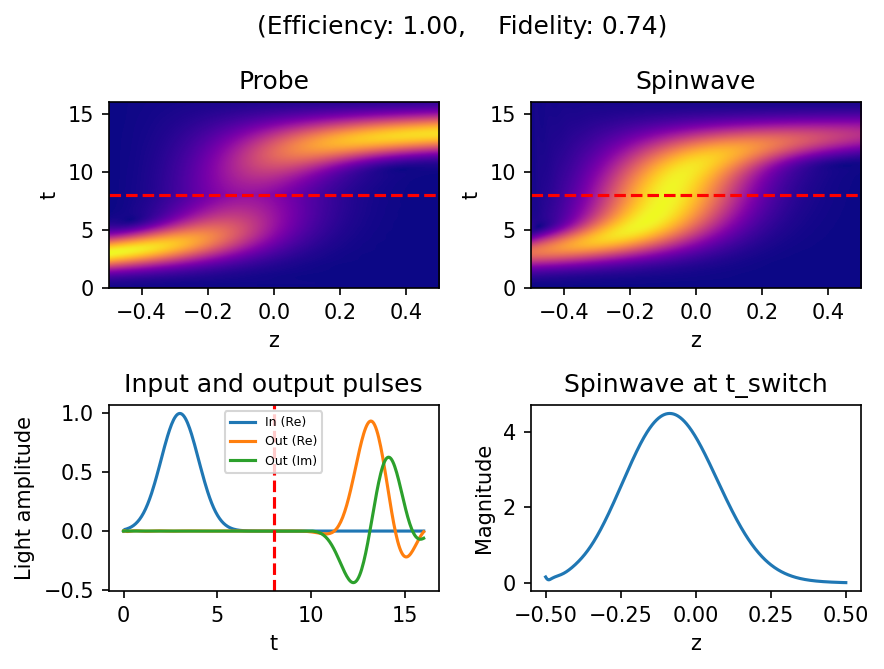

In [71]:
clipped_bw1 = load_instance("./instances/clipped-transform/bandwidth=1.0.h5")
summary_plot(*clipped_bw1, 8)

In [12]:
# Extreme case of transform clipping: turning any sufficiently-bright pulse into a full
# excitation of the cloud (i.e. a tophat) and hence an output sinc (which approaches a delta as 
# cloud bandwidth increases). 
# But note that in some sense this still preserves phase information between the
# different frequencies.
# Expanded upon later in the nonlinear-control-field section.

## Pulse squeezing

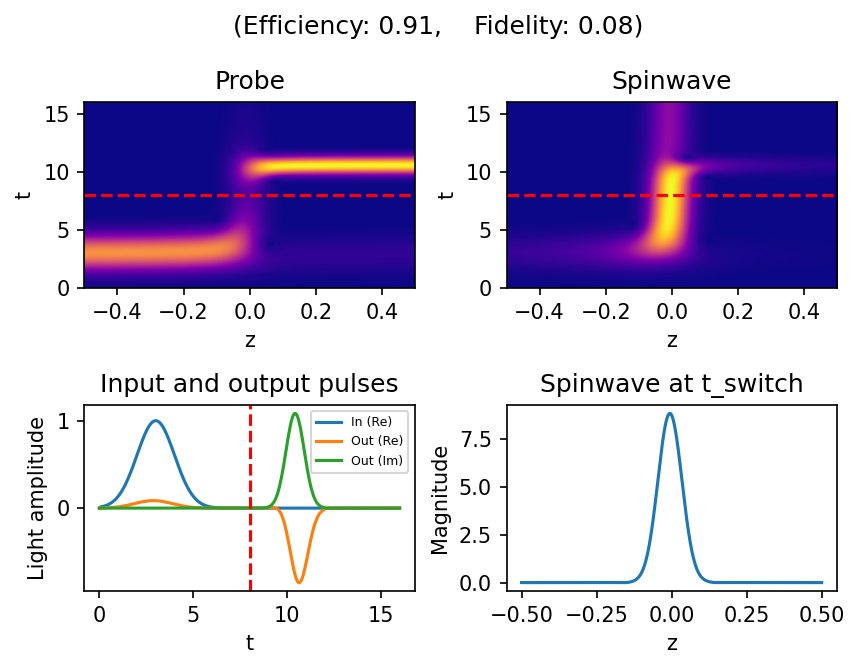

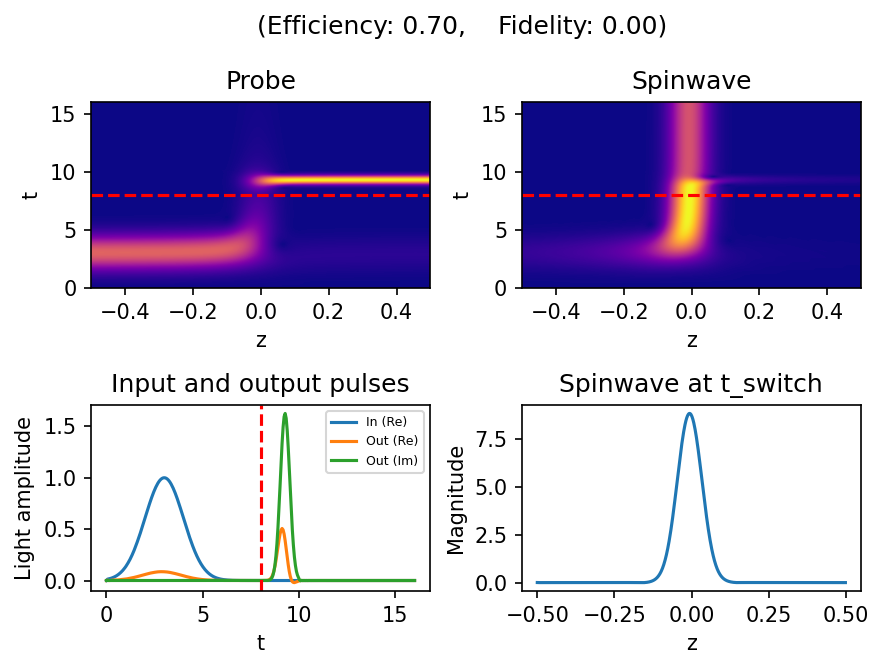

In [75]:
# Provied the conditions for retrieval (discussed above) are met,
# the squeezing of the signal is determined by the relative gradient
# between the input and output moments? 
# (i.e. the moments at which all the phases are coherent).
dilate05 = load_instance("./instances/squeezing/dilation=0.5.h5")
dilate20 = load_instance("./instances/squeezing/dilation=2.0.h5")
dilate40 = load_instance("./instances/squeezing/dilation=4.0.h5")
summary_plot(*dilate20, 8)
summary_plot(*dilate40, 8)

## Nonlinear control field

In [ ]:
# Scheme 1: correcting phase shift (?) and time-reversal using a bipartite control field.

In [16]:
# Key insight: provided we have an excess of light, the amount of light retained
# at a given frequency is (roughly) inversely proportional to the control gradient
# at the corresponding detuning.

In [17]:
# Extending the 'total-overflow transform clipping' technique:

# In general, using a nonlinear control field allows us to arbitrarily determine
# the magnitude profile of the Fourier transform, while preserving the phase relationship
# between frequencies. 
# Hence, when the inverse transform is taken, THIS CONVERTS FREQ-PHASE INFORMATION TO
# TIME-AMPLITUDE/PHASE INFORMATION
# TODO: scheme to retrieve this information (or choice of magnitude profile which makes this easy).

# Note that, for this purpose, the most efficient input pulse is a sinc, since it has uniform 

In [18]:
# Scheme 2: Have an asymmetric control field to perform convolution.
# For example, '_/--' will capture only frequencies in the range corresponding to /.
# This multiplies the Fourier transform by a tophat, and hence convolves the original
# function with a sinc.

In [19]:
# Effective depth optimisation using knowledge of the input freq-magnitude profile.

## Can we use a control field with time-dependent shape but carefully chosen so that we know the phase relationship, be used for computation?

## Other things that have previously been done

In [20]:
# TODO: recreate previous work.
# e.g. multi-mode/multi-signal storage